# Exploring Echoregions Regions2D Functionality

Prior to running this notebook and all other notebooks, make sure you have installed the packages found in `requirements.txt`.

This notebook parses region values from an Echoview `.evr` file and masks them over corresponding sonar data.

In [1]:
# Importing Packages
import matplotlib.pyplot as plt
import urllib.request
import shutil
import xarray as xr
import numpy as np
from pandas.testing import assert_frame_equal

import echoregions as er

### Regions Data Reading

To start this tutorial, we first download EVL data from Echoregion's github repository and parse the EVL file using Echoregion's `read_evr` function. 

The parsing is based off of the EVR data description shown on Echoview's website: https://support.echoview.com/WebHelp/Reference/File_Formats/Export_File_Formats/2D_Region_definition_file_format.htm.

In [2]:
# Set path to test data
TEST_DATA_PATH = 'https://raw.githubusercontent.com/OSOceanAcoustics/echoregions/update_notebook_docs_base_main/echoregions/test_data'

# Download example EVR File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.evr","transect.evr")

# Read EVR file
regions2d = er.read_evr('transect.evr')

#### Regions2D as a DataFrame

`regions2d` is a specialized object but it has a `data` attribute which is a simple dataframe.

In [3]:
# Grab regions2d dataframe
regions2d_df = regions2d.data

In [4]:
regions2d_df.head(3)

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
0,transect.evr,EVRG,7,13.0.378.44817,1,13,4,0,6,-1,...,2019-07-02 08:10:09.425500,-9999.99,9999.99,Log,2,COM,"[2019-07-02T03:50:54.629500000, 2019-07-02T03:...","[-9999.99, 9999.99, 9999.99, -9999.99]","[Switched from recording to ""night"" folder to ...",[]
1,transect.evr,EVRG,7,13.0.378.44817,2,13,4,0,6,-1,...,2019-07-02 12:32:31.740500,-9999.99,9999.99,Log,2,Com,"[2019-07-02T12:32:30.175500000, 2019-07-02T12:...","[-9999.99, 9999.99, 9999.99, -9999.99]",[Recording 10 min of passive data],[]
2,transect.evr,EVRG,7,13.0.378.44817,3,13,4,0,6,-1,...,2019-07-02 12:43:10.758500,-9999.99,9999.99,Log,2,COM,"[2019-07-02T12:43:06.273000000, 2019-07-02T12:...","[-9999.99, 9999.99, 9999.99, -9999.99]",[End passive data collection and back to active],[]


The `regions2d` object can be subsetted using the `select_region` function and with parameters related to region class, time, and depth. For this example let us select a hake region based on the `region_class` parameter:

In [5]:
trawl_region = regions2d.select_region(region_class="Hake")

In [6]:
trawl_region

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings


Now notice that this region is not closed:

In [7]:
for _, row in trawl_region.iterrows():
    plt.plot(row["time"], row["depth"])

We can close this region and re-plot:

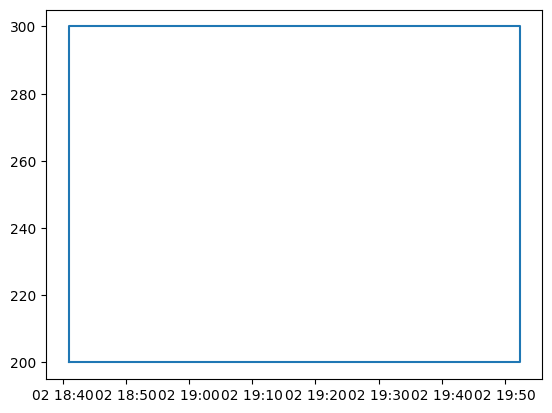

In [8]:
trawl_region_closed = regions2d.close_region(region_class="Trawl")

for _, row in trawl_region_closed.iterrows():
    plt.plot(row["time"], row["depth"])

To select Trawl, close regions, and plot this region, one can also just run the following using the object's `plot` function:

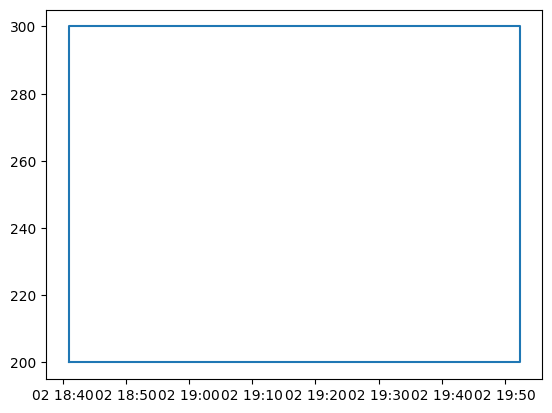

In [9]:
regions2d.plot(region_class="Trawl", close_regions=True)

### Sonar Data Reading and Plotting

Let's now download and plot some Sonar backscatter data created using Echopype. Echopype is a sonar backscatter parsing and scientific computation software for which Echoregions (a sonar annotation parsing software) is built to be used in conjunction with. For now, we will primarily be working with the `Sv` backscatter volume data variable, but there are many more data variables that can be used when parsing with Echopype.

More information regarding Echopype can be found here: https://echopype.readthedocs.io/en/stable/.

In [10]:
# Download example Echopype Sonar Zarr File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.zip","transect.zip")

# Extract the ZIP file
shutil.unpack_archive("transect.zip", "")

# Read EVL file
ds_Sv = xr.open_dataset('transect.zarr', engine="zarr")

In [11]:
ds_Sv["Sv"]

<xarray.DataArray 'Sv' (depth: 3955, ping_time: 1681, channel: 3)>
[19945065 values with dtype=float64]
Coordinates:
  * channel       (channel) <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ... '...
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    range_sample  (depth) int64 ...
Attributes:
    actual_range:  [-156.0, 37.68]
    long_name:     Volume backscattering strength (Sv re 1 m-1)
    units:         dB

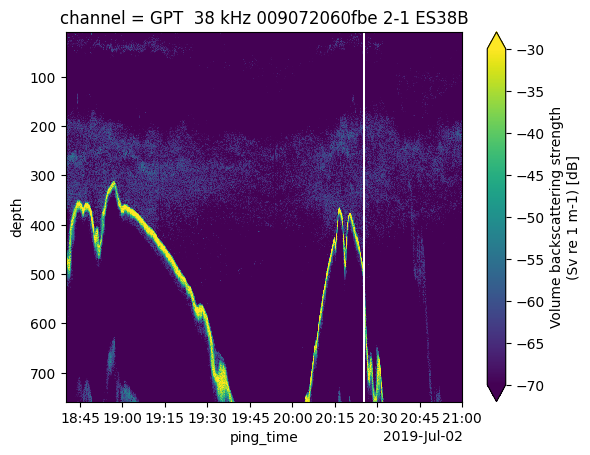

In [12]:
# Plot the 38 kHz backscatter channel
ds_Sv["Sv"].isel(channel=1).plot(y="depth", yincrease=False, vmin=-70, vmax=-30)

### Plotting and Masking Sonar and Region

From the two previous plots, one can kind of see how they're related on both the depth and time dimensions. Now let's see a region annotation overlayed on top of the Sonar dataset.

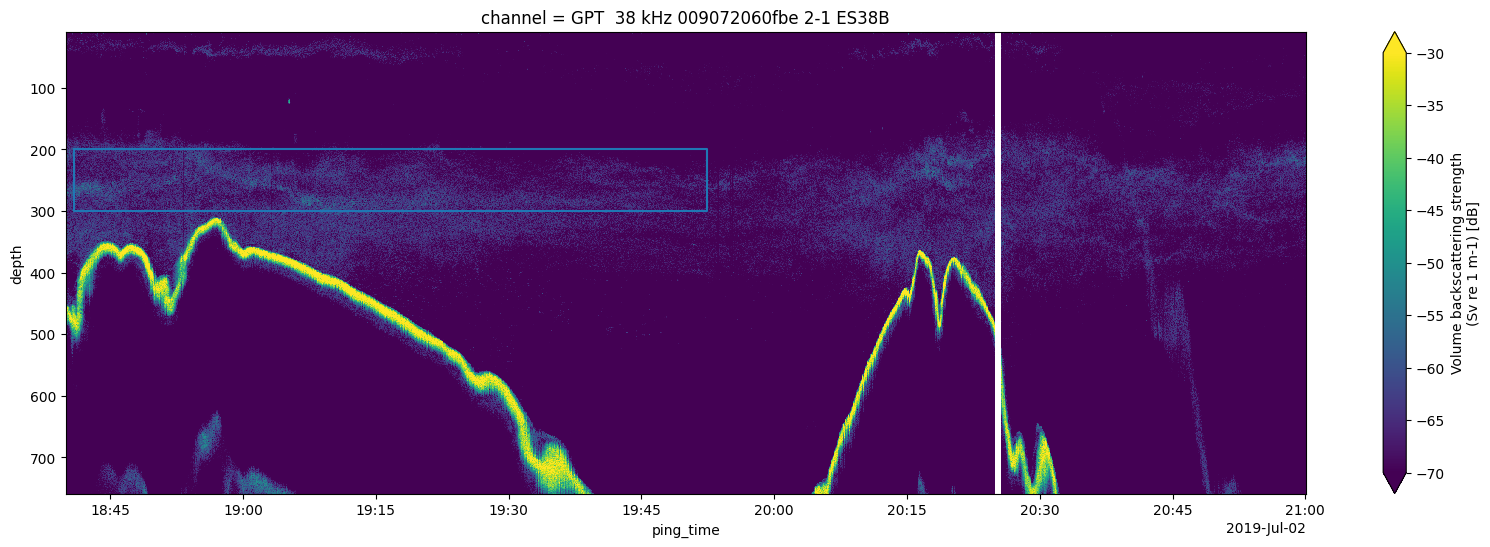

In [13]:
# Plotting the sonar data and the trawl region
plt.figure(figsize = (20, 6))
for _, row in trawl_region_closed.iterrows():
    plt.plot(row["time"], row["depth"],fillstyle='full', markersize=1)
ds_Sv.Sv.isel(channel=1).T.plot(y="depth", yincrease=False, vmin=-70, vmax=-30)

We can see that there is clear overlap between the two pieces of data here. However, for machine learning training purposes, and more specifically, for computer vision segmentation model training, point data is not enough and so we require masks of the sonar data.

The `Regions2D` class has a function to do this specific task: `mask`. This `mask` function is essentially a wrapper over the `mask_3D` from [regionmask](https://github.com/regionmask/regionmask).

In [42]:
# Use the built in mask function to create a mask
region_mask_ds, region_contours = regions2d.mask(
    ds_Sv["Sv"].isel(channel=1).drop_vars("channel").compute(),
    region_class="Trawl",
)

The output should be the region mask itself and the points that constitute the region mask.

Note that even though we use `region_class` here to select the region to be masked, what is stored in the dataset as a dimension is the `region_id` since `region_id` is the unique identifier of the region:

In [15]:
region_mask_ds

<xarray.Dataset>
Dimensions:      (region_id: 1, depth: 3955, ping_time: 1681)
Coordinates:
  * region_id    (region_id) int64 18
  * depth        (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
  * ping_time    (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-0...
Data variables:
    mask_labels  (region_id) int64 17
    mask_3d      (region_id, depth, ping_time) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

As a sanity check, let us check that the `ping_time` and `depth` dimensions in the region mask `region_mask_ds` are equal to that in the backscatter sonar data `ds_Sv["Sv]`:

In [16]:
print(
    "Region Mask Ping Time Dimension Length:",
    len(region_mask_ds["ping_time"])
)
print(
    "Region Mask Depth Dimension Length:",
    len(region_mask_ds["depth"])
)
print(
    "Backscatter Sonar Ping Time Dimension Length:",
    len(ds_Sv["Sv"]["ping_time"])
)
print(
    "Backscatter Sonar Depth Dimension Length:",
    len(ds_Sv["Sv"]["depth"])
)

Region Mask Ping Time Dimension Length: 1681
Region Mask Depth Dimension Length: 3955
Backscatter Sonar Ping Time Dimension Length: 1681
Backscatter Sonar Depth Dimension Length: 3955


The values in the region mask should also just be 1s and 0s:

In [17]:
print("Unique Values in Region Mask:", np.unique(region_mask_ds["mask_3d"].data))

Unique Values in Region Mask: [0 1]


A plot of the mask itself:

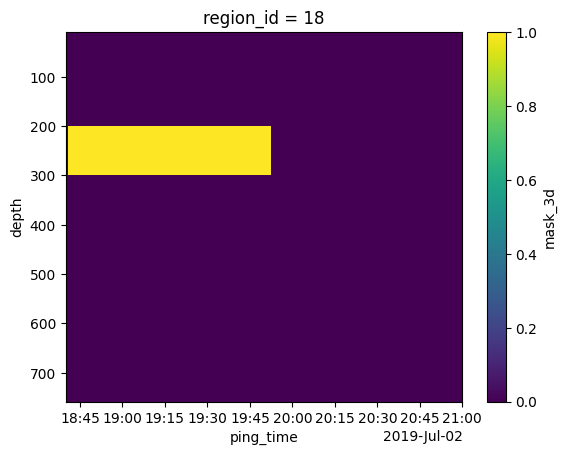

In [18]:
region_mask_ds["mask_3d"].plot(y="depth", yincrease=False)

A plot of the 38 kHz channel where the mask exists:

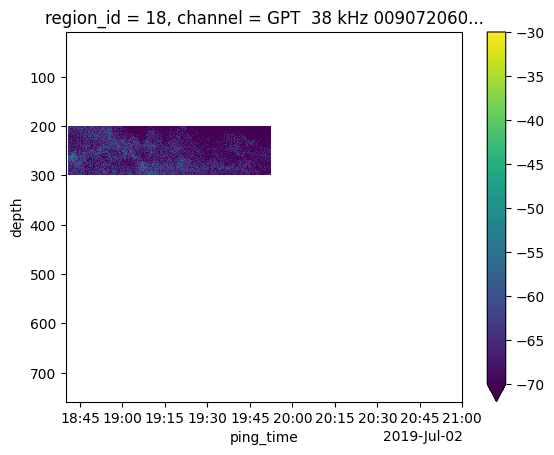

In [19]:
# Get only 38 kHz channel values where the mask is 1
mask_exists_Sv = xr.where(
    region_mask_ds["mask_3d"] == 1,
    ds_Sv["Sv"].isel(channel=1),
    np.nan,
)

# Plot the masked Sv
mask_exists_Sv.plot(y="depth", yincrease=False, vmin=-70, vmax=-30)

### Saving to CSV and Reading From CSV

So now that we have our mask and our new interpolated region points, how do we save them?

We can use the Echoregions `read_regions_csv` function to first load it onto a region2d object and use the region2d object's `to_csv` function to save the regions2d dataframe as a CSV.

In [48]:
# Create new regions2d object
from_mask_regions = er.read_regions_csv(region_contours)

# Save to CSV
from_mask_regions.to_csv("from_mask_regions.csv", index=False)

Now if you need to load this CSV into a regions object we can again use `read_regions_csv` since it takes in both file locations (Path/str objects) and Pandas DataFrames:

In [49]:
# Create another new regions2d object
from_csv_regions = er.read_regions_csv("from_mask_regions.csv")

As another sanity check, let's check if these dataframes are equal (with index reset):

In [59]:
try:
    assert_frame_equal(from_mask_regions.data.reset_index(drop=True), from_csv_regions.data.reset_index(drop=True))
    print("The two DataFrames are equal.")
except AssertionError:
    print("The two DataFrames are not equal.")

The two DataFrames are equal.
